Acknowledgement: This code was initially inspired by the lab "COMP34212_Lab2b_Keras_CNN_CIFAR_2025" before undergoing significant changes.

# Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Input, Add
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

print('Libraries imported.')

Libraries imported.


# Data Preperation

In [ ]:



cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

cifar100_coarse_labels = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects', 'large carnivores',
    'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
    'trees', 'vehicles 1', 'vehicles 2'
]


fine_to_coarse_mapping = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7,
    8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11,
    16: 3, 17: 9, 18: 7, 19: 11, 20: 6, 21: 11, 22: 5, 23: 10,
    24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0, 31: 11,
    32: 1, 33: 10, 34: 12, 35: 14, 36: 16, 37: 9, 38: 11, 39: 5,
    40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17,
    48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2, 55: 0,
    56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
    64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10,
    72: 0, 73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13,
    80: 16, 81: 18, 82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5,
    88: 8, 89: 19, 90: 18, 91: 1, 92: 2, 93: 15, 94: 6, 95: 0,
    96: 17, 97: 8, 98: 14, 99: 13
}

In [ ]:

BATCH_SIZE = 256
N_EPOCH = 75
N_CLASSES = 100
N_SUPERCLASSES = 20
VERBOSE = 1
VALIDATION_SPLIT = 0.2

print('Main variables initialised.')


IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

print('Image variables initialisation')


Main variables initialised.
Image variables initialisation


In [ ]:

(input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data(label_mode='fine')
print('input_X_train shape:', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')


output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES)


input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
input_X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Sample input image class: apple


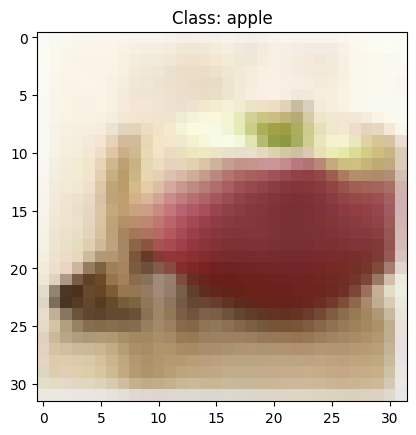

Sample input image class: boy


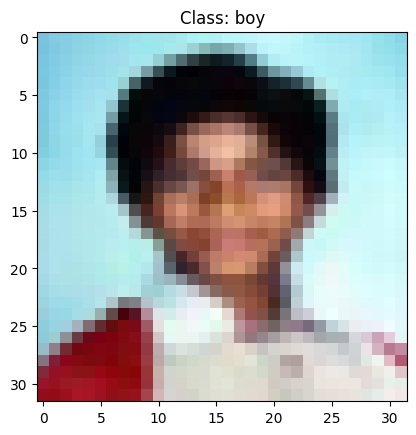

In [ ]:

Selected_Image = 2
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

Selected_Image = 3
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

# Training

In [ ]:
def identity_block(x, filters, dropout_rate):
    x_skip = x


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)


    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:
def conv_block(x, filters, stride, dropout_rate):
    x_skip = x


    x = Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)


    x_skip = Conv2D(filters, 1, strides=stride, padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:

inputs = Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))


x = Conv2D(64, 3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)




x = conv_block(x, 64, stride=1, dropout_rate=0.3)
x = identity_block(x, 64, dropout_rate=0.3)


x = conv_block(x, 128, stride=2, dropout_rate=0.3)
x = identity_block(x, 128, dropout_rate=0.3)


x = conv_block(x, 256, stride=2, dropout_rate=0.3)
x = identity_block(x, 256, dropout_rate=0.3)


x = Dropout(0.2)(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(N_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
class TrainingMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        print(f"\nEpoch {epoch+1}")
        print(f"LR: {lr:.1e}\n")
        print(f"  Training Loss: {logs['loss']:.4f} - Training Accuracy: {logs['accuracy']:.4f}")
        print(f"  Validation Loss: {logs['val_loss']:.4f} - Validation Accuracy: {logs['val_accuracy']:.4f}")
        if logs['accuracy'] - logs['val_accuracy'] > 0.15:
            print(f"! Overfitting: {logs['accuracy']-logs['val_accuracy']:.4f} gap")



In [ ]:


initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=N_EPOCH * (len(input_X_train)//BATCH_SIZE)
)
OPTIM1 = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=0.01,
    global_clipnorm=1.0
)

model.compile(loss='categorical_crossentropy', optimizer=OPTIM1, metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │          4,160 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ dropout[0][0],         │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activat

 Total params: 2,811,940 (10.73 MB)

 Trainable params: 2,807,332 (10.71 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [ ]:

early_stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=8,
    restore_best_weights=True,
    start_from_epoch=10
)

In [ ]:

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    input_X_train, output_Y_train,
    batch_size=BATCH_SIZE,
    epochs=N_EPOCH,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
    callbacks=[
        early_stop,
        checkpoint,
        TrainingMonitor(),
    ]
)


Epoch 1/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.0923 - loss: 4.0549
Epoch 1: val_accuracy improved from -inf to 0.01210, saving model to best_model.h5



Epoch 1
LR: 1.0e-03

  Training Loss: 3.6635 - Training Accuracy: 0.1418
  Validation Loss: 11.1427 - Validation Accuracy: 0.0121
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 148ms/step - accuracy: 0.0926 - loss: 4.0524 - val_accuracy: 0.0121 - val_loss: 11.1427
Epoch 2/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2530 - loss: 2.9903
Epoch 2: val_accuracy improved from 0.01210 to 0.04390, saving model to best_model.h5



Epoch 2
LR: 1.0e-03

  Training Loss: 2.8637 - Training Accuracy: 0.2763
  Validation Loss: 5.8086 - Validation Accuracy: 0.0439
! Overfitting: 0.2324 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.2532 - loss: 2.9895 - val_accuracy: 0.0439 - val_loss: 5.8086
Epoch 3/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3481 - loss: 2.4972
Epoch 3: val_accuracy improved from 0.04390 to 0.18780, saving model to best_model.h5



Epoch 3
LR: 1.0e-03

  Training Loss: 2.4470 - Training Accuracy: 0.3590
  Validation Loss: 3.5231 - Validation Accuracy: 0.1878
! Overfitting: 0.1712 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3482 - loss: 2.4969 - val_accuracy: 0.1878 - val_loss: 3.5231
Epoch 4/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4085 - loss: 2.2203
Epoch 4: val_accuracy improved from 0.18780 to 0.26310, saving model to best_model.h5



Epoch 4
LR: 1.0e-03

  Training Loss: 2.1735 - Training Accuracy: 0.4170
  Validation Loss: 3.2472 - Validation Accuracy: 0.2631
! Overfitting: 0.1539 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4086 - loss: 2.2194 - val_accuracy: 0.2631 - val_loss: 3.2472
Epoch 5/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4593 - loss: 1.9781
Epoch 5: val_accuracy improved from 0.26310 to 0.35590, saving model to best_model.h5



Epoch 5
LR: 9.9e-04

  Training Loss: 1.9547 - Training Accuracy: 0.4658
  Validation Loss: 2.5773 - Validation Accuracy: 0.3559
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4594 - loss: 1.9776 - val_accuracy: 0.3559 - val_loss: 2.5773
Epoch 6/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5026 - loss: 1.7862
Epoch 6: val_accuracy improved from 0.35590 to 0.38200, saving model to best_model.h5



Epoch 6
LR: 9.9e-04

  Training Loss: 1.7918 - Training Accuracy: 0.5036
  Validation Loss: 2.5251 - Validation Accuracy: 0.3820
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5026 - loss: 1.7862 - val_accuracy: 0.3820 - val_loss: 2.5251
Epoch 7/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5441 - loss: 1.6385
Epoch 7: val_accuracy improved from 0.38200 to 0.39940, saving model to best_model.h5



Epoch 7
LR: 9.9e-04

  Training Loss: 1.6310 - Training Accuracy: 0.5443
  Validation Loss: 2.4164 - Validation Accuracy: 0.3994
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5441 - loss: 1.6383 - val_accuracy: 0.3994 - val_loss: 2.4164
Epoch 8/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5762 - loss: 1.5099
Epoch 8: val_accuracy improved from 0.39940 to 0.46270, saving model to best_model.h5



Epoch 8
LR: 9.8e-04

  Training Loss: 1.5042 - Training Accuracy: 0.5766
  Validation Loss: 2.0952 - Validation Accuracy: 0.4627
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5762 - loss: 1.5098 - val_accuracy: 0.4627 - val_loss: 2.0952
Epoch 9/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6084 - loss: 1.3682
Epoch 9: val_accuracy did not improve from 0.46270

Epoch 9
LR: 9.8e-04

  Training Loss: 1.3846 - Training Accuracy: 0.6036
  Validation Loss: 2.3224 - Validation Accuracy: 0.4280
! Overfitting: 0.1756 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6084 - loss: 1.3683 - val_accuracy: 0.4280 - val_loss: 2.3224
Epoch 10/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6428 - loss: 1.2526
Epoch 10: val_accuracy improved from 0.46270 to 0.49670, saving model to best_model.h5



Epoch 10
LR: 9.7e-04

  Training Loss: 1.2731 - Training Accuracy: 0.6327
  Validation Loss: 1.9122 - Validation Accuracy: 0.4967
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6427 - loss: 1.2529 - val_accuracy: 0.4967 - val_loss: 1.9122
Epoch 11/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6663 - loss: 1.1594
Epoch 11: val_accuracy did not improve from 0.49670

Epoch 11
LR: 9.7e-04

  Training Loss: 1.1737 - Training Accuracy: 0.6598
  Validation Loss: 2.0185 - Validation Accuracy: 0.4820
! Overfitting: 0.1778 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6661 - loss: 1.1597 - val_accuracy: 0.4820 - val_loss: 2.0185
Epoch 12/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6906 - loss: 1.0517
Epoch 12: val_accuracy did not improve from 0.49670

Epoch 12
LR: 9.6e-04

  Training Loss: 1.0776 - Training Accuracy: 0.6813
  Validation Loss: 2.3089 - Validation Accuracy: 0.4462
! Overfitting: 0.2351 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/st


Epoch 13
LR: 9.5e-04

  Training Loss: 0.9853 - Training Accuracy: 0.7118
  Validation Loss: 1.7739 - Validation Accuracy: 0.5298
! Overfitting: 0.1820 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7213 - loss: 0.9611 - val_accuracy: 0.5298 - val_loss: 1.7739
Epoch 14/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7487 - loss: 0.8538
Epoch 14: val_accuracy did not improve from 0.52980

Epoch 14
LR: 9.5e-04

  Training Loss: 0.8874 - Training Accuracy: 0.7360
  Validation Loss: 2.0635 - Validation Accuracy: 0.5034
! Overfitting: 0.2326 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7486 - loss: 0.8542 - val_accuracy: 0.5034 - val_loss: 2.0635
Epoch 15/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7670 - loss: 0.7790
Epoch 15: val_accuracy did not improve from 0.52980

Epoch 15
LR: 9.4e-04

  Training Loss: 0.8069 - Training Accuracy: 0.7574
  Validation Loss: 2.2092 - Validation Accuracy: 0.4616
! Overfitting: 0.2958 gap
157/157 ━━━━━


Epoch 17
LR: 9.2e-04

  Training Loss: 0.6510 - Training Accuracy: 0.8025
  Validation Loss: 1.8943 - Validation Accuracy: 0.5359
! Overfitting: 0.2666 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8115 - loss: 0.6288 - val_accuracy: 0.5359 - val_loss: 1.8943
Epoch 18/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8327 - loss: 0.5577
Epoch 18: val_accuracy did not improve from 0.53590

Epoch 18
LR: 9.1e-04

  Training Loss: 0.5843 - Training Accuracy: 0.8246
  Validation Loss: 1.9153 - Validation Accuracy: 0.5332
! Overfitting: 0.2914 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8327 - loss: 0.5579 - val_accuracy: 0.5332 - val_loss: 1.9153
Epoch 19/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8583 - loss: 0.4756
Epoch 19: val_accuracy did not improve from 0.53590

Epoch 19
LR: 9.0e-04

  Training Loss: 0.5039 - Training Accuracy: 0.8483
  Validation Loss: 2.2293 - Validation Accuracy: 0.5008
! Overfitting: 0.3475 gap
157/157 ━━━━━


Epoch 22
LR: 8.7e-04

  Training Loss: 0.3631 - Training Accuracy: 0.8906
  Validation Loss: 1.9448 - Validation Accuracy: 0.5577
! Overfitting: 0.3329 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8987 - loss: 0.3412 - val_accuracy: 0.5577 - val_loss: 1.9448
Epoch 23/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9075 - loss: 0.3113
Epoch 23: val_accuracy did not improve from 0.55770

Epoch 23
LR: 8.6e-04

  Training Loss: 0.3259 - Training Accuracy: 0.9017
  Validation Loss: 2.0903 - Validation Accuracy: 0.5481
! Overfitting: 0.3536 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9074 - loss: 0.3115 - val_accuracy: 0.5481 - val_loss: 2.0903
Epoch 24/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9213 - loss: 0.2676
Epoch 24: val_accuracy did not improve from 0.55770

Epoch 24
LR: 8.4e-04

  Training Loss: 0.2799 - Training Accuracy: 0.9165
  Validation Loss: 2.1080 - Validation Accuracy: 0.5460
! Overfitting: 0.3705 gap
157/157 ━━━━━


Epoch 30
LR: 7.7e-04

  Training Loss: 0.1503 - Training Accuracy: 0.9562
  Validation Loss: 2.2085 - Validation Accuracy: 0.5716
! Overfitting: 0.3846 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9597 - loss: 0.1433 - val_accuracy: 0.5716 - val_loss: 2.2085
Epoch 31/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9640 - loss: 0.1282
Epoch 31: val_accuracy did not improve from 0.57160

Epoch 31
LR: 7.5e-04

  Training Loss: 0.1324 - Training Accuracy: 0.9620
  Validation Loss: 2.3631 - Validation Accuracy: 0.5588
! Overfitting: 0.4032 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9640 - loss: 0.1283 - val_accuracy: 0.5588 - val_loss: 2.3631
Epoch 32/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9672 - loss: 0.1181
Epoch 32: val_accuracy did not improve from 0.57160

Epoch 32
LR: 7.4e-04

  Training Loss: 0.1271 - Training Accuracy: 0.9637
  Validation Loss: 2.4102 - Validation Accuracy: 0.5550
! Overfitting: 0.4087 gap
157/157 ━━━━━


Epoch 34
LR: 7.1e-04

  Training Loss: 0.1067 - Training Accuracy: 0.9701
  Validation Loss: 2.2880 - Validation Accuracy: 0.5793
! Overfitting: 0.3908 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9723 - loss: 0.1027 - val_accuracy: 0.5793 - val_loss: 2.2880
Epoch 35/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9739 - loss: 0.0931
Epoch 35: val_accuracy improved from 0.57930 to 0.58180, saving model to best_model.h5



Epoch 35
LR: 6.9e-04

  Training Loss: 0.0991 - Training Accuracy: 0.9719
  Validation Loss: 2.2821 - Validation Accuracy: 0.5818
! Overfitting: 0.3902 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9739 - loss: 0.0931 - val_accuracy: 0.5818 - val_loss: 2.2821
Epoch 36/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9756 - loss: 0.0875
Epoch 36: val_accuracy improved from 0.58180 to 0.58340, saving model to best_model.h5



Epoch 36
LR: 6.7e-04

  Training Loss: 0.0917 - Training Accuracy: 0.9746
  Validation Loss: 2.3130 - Validation Accuracy: 0.5834
! Overfitting: 0.3912 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9756 - loss: 0.0876 - val_accuracy: 0.5834 - val_loss: 2.3130
Epoch 37/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9768 - loss: 0.0844
Epoch 37: val_accuracy did not improve from 0.58340

Epoch 37
LR: 6.6e-04

  Training Loss: 0.0871 - Training Accuracy: 0.9754
  Validation Loss: 2.5084 - Validation Accuracy: 0.5699
! Overfitting: 0.4055 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9767 - loss: 0.0845 - val_accuracy: 0.5699 - val_loss: 2.5084
Epoch 38/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9798 - loss: 0.0739
Epoch 38: val_accuracy did not improve from 0.58340

Epoch 38
LR: 6.4e-04

  Training Loss: 0.0762 - Training Accuracy: 0.9791
  Validation Loss: 2.4159 - Validation Accuracy: 0.5758
! Overfitting: 0.4033 gap
157/157 ━━━━━


Epoch 39
LR: 6.3e-04

  Training Loss: 0.0721 - Training Accuracy: 0.9793
  Validation Loss: 2.2566 - Validation Accuracy: 0.5947
! Overfitting: 0.3846 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9811 - loss: 0.0673 - val_accuracy: 0.5947 - val_loss: 2.2566
Epoch 40/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9832 - loss: 0.0615
Epoch 40: val_accuracy did not improve from 0.59470

Epoch 40
LR: 6.1e-04

  Training Loss: 0.0658 - Training Accuracy: 0.9814
  Validation Loss: 2.8476 - Validation Accuracy: 0.5347
! Overfitting: 0.4467 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9832 - loss: 0.0616 - val_accuracy: 0.5347 - val_loss: 2.8476
Epoch 41/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9845 - loss: 0.0587
Epoch 41: val_accuracy did not improve from 0.59470

Epoch 41
LR: 5.9e-04

  Training Loss: 0.0623 - Training Accuracy: 0.9825
  Validation Loss: 2.4892 - Validation Accuracy: 0.5689
! Overfitting: 0.4136 gap
157/157 ━━━━━


Epoch 47
LR: 4.9e-04

  Training Loss: 0.0386 - Training Accuracy: 0.9900
  Validation Loss: 2.3504 - Validation Accuracy: 0.6011
! Overfitting: 0.3889 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9907 - loss: 0.0371 - val_accuracy: 0.6011 - val_loss: 2.3504
Epoch 48/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9914 - loss: 0.0350
Epoch 48: val_accuracy did not improve from 0.60110

Epoch 48
LR: 4.8e-04

  Training Loss: 0.0365 - Training Accuracy: 0.9910
  Validation Loss: 2.5415 - Validation Accuracy: 0.5838
! Overfitting: 0.4072 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9913 - loss: 0.0350 - val_accuracy: 0.5838 - val_loss: 2.5415
Epoch 49/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9930 - loss: 0.0302
Epoch 49: val_accuracy improved from 0.60110 to 0.60160, saving model to best_model.h5



Epoch 49
LR: 4.6e-04

  Training Loss: 0.0309 - Training Accuracy: 0.9923
  Validation Loss: 2.4400 - Validation Accuracy: 0.6016
! Overfitting: 0.3907 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9929 - loss: 0.0302 - val_accuracy: 0.6016 - val_loss: 2.4400
Epoch 50/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9928 - loss: 0.0282
Epoch 50: val_accuracy did not improve from 0.60160

Epoch 50
LR: 4.4e-04

  Training Loss: 0.0286 - Training Accuracy: 0.9932
  Validation Loss: 2.4114 - Validation Accuracy: 0.6004
! Overfitting: 0.3928 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9928 - loss: 0.0282 - val_accuracy: 0.6004 - val_loss: 2.4114
Epoch 51/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9942 - loss: 0.0256
Epoch 51: val_accuracy improved from 0.60160 to 0.60530, saving model to best_model.h5



Epoch 51
LR: 4.3e-04

  Training Loss: 0.0263 - Training Accuracy: 0.9936
  Validation Loss: 2.3762 - Validation Accuracy: 0.6053
! Overfitting: 0.3882 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9942 - loss: 0.0256 - val_accuracy: 0.6053 - val_loss: 2.3762
Epoch 52/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9939 - loss: 0.0244
Epoch 52: val_accuracy did not improve from 0.60530

Epoch 52
LR: 4.1e-04

  Training Loss: 0.0238 - Training Accuracy: 0.9946
  Validation Loss: 2.4028 - Validation Accuracy: 0.6044
! Overfitting: 0.3902 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9939 - loss: 0.0244 - val_accuracy: 0.6044 - val_loss: 2.4028
Epoch 53/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9953 - loss: 0.0211
Epoch 53: val_accuracy improved from 0.60530 to 0.60980, saving model to best_model.h5



Epoch 53
LR: 3.9e-04

  Training Loss: 0.0222 - Training Accuracy: 0.9951
  Validation Loss: 2.3699 - Validation Accuracy: 0.6098
! Overfitting: 0.3853 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9953 - loss: 0.0211 - val_accuracy: 0.6098 - val_loss: 2.3699
Epoch 54/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9953 - loss: 0.0207
Epoch 54: val_accuracy improved from 0.60980 to 0.61390, saving model to best_model.h5



Epoch 54
LR: 3.8e-04

  Training Loss: 0.0200 - Training Accuracy: 0.9957
  Validation Loss: 2.3886 - Validation Accuracy: 0.6139
! Overfitting: 0.3818 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9953 - loss: 0.0207 - val_accuracy: 0.6139 - val_loss: 2.3886
Epoch 55/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9962 - loss: 0.0166
Epoch 55: val_accuracy improved from 0.61390 to 0.61830, saving model to best_model.h5



Epoch 55
LR: 3.6e-04

  Training Loss: 0.0170 - Training Accuracy: 0.9963
  Validation Loss: 2.2971 - Validation Accuracy: 0.6183
! Overfitting: 0.3780 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9962 - loss: 0.0166 - val_accuracy: 0.6183 - val_loss: 2.2971
Epoch 56/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9965 - loss: 0.0162
Epoch 56: val_accuracy did not improve from 0.61830

Epoch 56
LR: 3.4e-04

  Training Loss: 0.0155 - Training Accuracy: 0.9969
  Validation Loss: 2.3194 - Validation Accuracy: 0.6183
! Overfitting: 0.3786 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9965 - loss: 0.0162 - val_accuracy: 0.6183 - val_loss: 2.3194
Epoch 57/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9975 - loss: 0.0124
Epoch 57: val_accuracy improved from 0.61830 to 0.62490, saving model to best_model.h5



Epoch 57
LR: 3.3e-04

  Training Loss: 0.0122 - Training Accuracy: 0.9978
  Validation Loss: 2.2553 - Validation Accuracy: 0.6249
! Overfitting: 0.3729 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9975 - loss: 0.0124 - val_accuracy: 0.6249 - val_loss: 2.2553
Epoch 58/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9984 - loss: 0.0102
Epoch 58: val_accuracy did not improve from 0.62490

Epoch 58
LR: 3.1e-04

  Training Loss: 0.0106 - Training Accuracy: 0.9981
  Validation Loss: 2.4149 - Validation Accuracy: 0.6128
! Overfitting: 0.3853 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9984 - loss: 0.0102 - val_accuracy: 0.6128 - val_loss: 2.4149
Epoch 59/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9983 - loss: 0.0103
Epoch 59: val_accuracy did not improve from 0.62490

Epoch 59
LR: 3.0e-04

  Training Loss: 0.0108 - Training Accuracy: 0.9979
  Validation Loss: 2.3421 - Validation Accuracy: 0.6201
! Overfitting: 0.3778 gap
157/157 ━━━━━


Epoch 61
LR: 2.7e-04

  Training Loss: 0.0090 - Training Accuracy: 0.9986
  Validation Loss: 2.3195 - Validation Accuracy: 0.6264
! Overfitting: 0.3722 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9988 - loss: 0.0087 - val_accuracy: 0.6264 - val_loss: 2.3195
Epoch 62/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9982 - loss: 0.0089
Epoch 62: val_accuracy improved from 0.62640 to 0.62740, saving model to best_model.h5



Epoch 62
LR: 2.5e-04

  Training Loss: 0.0092 - Training Accuracy: 0.9982
  Validation Loss: 2.2833 - Validation Accuracy: 0.6274
! Overfitting: 0.3708 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9982 - loss: 0.0089 - val_accuracy: 0.6274 - val_loss: 2.2833
Epoch 63/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9988 - loss: 0.0072
Epoch 63: val_accuracy improved from 0.62740 to 0.63680, saving model to best_model.h5



Epoch 63
LR: 2.4e-04

  Training Loss: 0.0070 - Training Accuracy: 0.9990
  Validation Loss: 2.2332 - Validation Accuracy: 0.6368
! Overfitting: 0.3622 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9988 - loss: 0.0072 - val_accuracy: 0.6368 - val_loss: 2.2332
Epoch 64/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9991 - loss: 0.0061
Epoch 64: val_accuracy did not improve from 0.63680

Epoch 64
LR: 2.2e-04

  Training Loss: 0.0063 - Training Accuracy: 0.9991
  Validation Loss: 2.2400 - Validation Accuracy: 0.6343
! Overfitting: 0.3648 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9991 - loss: 0.0061 - val_accuracy: 0.6343 - val_loss: 2.2400
Epoch 65/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9990 - loss: 0.0063
Epoch 65: val_accuracy did not improve from 0.63680

Epoch 65
LR: 2.1e-04

  Training Loss: 0.0071 - Training Accuracy: 0.9989
  Validation Loss: 2.2785 - Validation Accuracy: 0.6305
! Overfitting: 0.3684 gap
157/157 ━━━━━


Epoch 69
LR: 1.6e-04

  Training Loss: 0.0042 - Training Accuracy: 0.9996
  Validation Loss: 2.2459 - Validation Accuracy: 0.6380
! Overfitting: 0.3616 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9996 - loss: 0.0041 - val_accuracy: 0.6380 - val_loss: 2.2459
Epoch 70/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9997 - loss: 0.0038
Epoch 70: val_accuracy improved from 0.63800 to 0.64240, saving model to best_model.h5



Epoch 70
LR: 1.4e-04

  Training Loss: 0.0041 - Training Accuracy: 0.9996
  Validation Loss: 2.2265 - Validation Accuracy: 0.6424
! Overfitting: 0.3572 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9997 - loss: 0.0038 - val_accuracy: 0.6424 - val_loss: 2.2265
Epoch 71/75
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9994 - loss: 0.0039
Epoch 71: val_accuracy did not improve from 0.64240

Epoch 71
LR: 1.3e-04

  Training Loss: 0.0040 - Training Accuracy: 0.9995
  Validation Loss: 2.2252 - Validation Accuracy: 0.6405
! Overfitting: 0.3590 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9994 - loss: 0.0039 - val_accuracy: 0.6405 - val_loss: 2.2252
Epoch 72/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9997 - loss: 0.0038
Epoch 72: val_accuracy did not improve from 0.64240

Epoch 72
LR: 1.2e-04

  Training Loss: 0.0036 - Training Accuracy: 0.9997
  Validation Loss: 2.2296 - Validation Accuracy: 0.6407
! Overfitting: 0.3590 gap
157/157 ━━━━━


Epoch 73
LR: 1.1e-04

  Training Loss: 0.0038 - Training Accuracy: 0.9995
  Validation Loss: 2.2119 - Validation Accuracy: 0.6445
! Overfitting: 0.3550 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9994 - loss: 0.0038 - val_accuracy: 0.6445 - val_loss: 2.2119
Epoch 74/75
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9997 - loss: 0.0030
Epoch 74: val_accuracy did not improve from 0.64450

Epoch 74
LR: 1.0e-04

  Training Loss: 0.0031 - Training Accuracy: 0.9996
  Validation Loss: 2.2387 - Validation Accuracy: 0.6404
! Overfitting: 0.3592 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9997 - loss: 0.0030 - val_accuracy: 0.6404 - val_loss: 2.2387
Epoch 75/75
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9996 - loss: 0.0031
Epoch 75: val_accuracy improved from 0.64450 to 0.64480, saving model to best_model.h5



Epoch 75
LR: 9.1e-05

  Training Loss: 0.0034 - Training Accuracy: 0.9996
  Validation Loss: 2.1960 - Validation Accuracy: 0.6448
! Overfitting: 0.3548 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9996 - loss: 0.0031 - val_accuracy: 0.6448 - val_loss: 2.1960


In [ ]:

predictions = model.predict(input_X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(output_Y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


## Evaluation

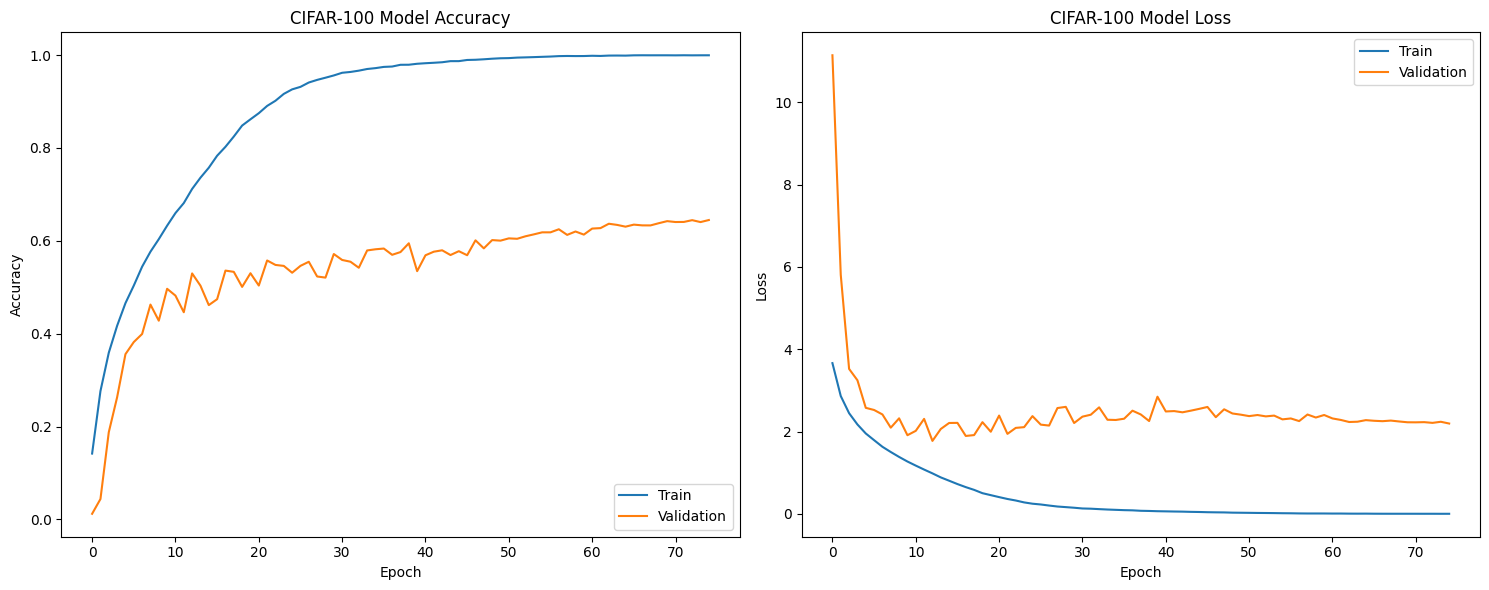

In [ ]:


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CIFAR-100 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CIFAR-100 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:


test_loss, test_accuracy = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


superclass_y_true = np.array([fine_to_coarse_mapping[y] for y in y_true])
superclass_y_pred = np.array([fine_to_coarse_mapping[y] for y in y_pred])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6520 - loss: 2.2085

Test Loss: 2.2093
Test Accuracy: 0.6482
